# Set up environment

In [1]:
import math, re, os, sys
import warnings
import functools
import types
import enum
import pickle
import gc
import contextlib
import multiprocessing as mp
import json
import traceback 

import numpy as np
import scipy as sp
import pandas as pd

import cv2

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_addons.image
import tensorflow_hub as tfhub

import sklearn as sk
import sklearn.model_selection

from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient

import google.cloud

In [2]:
# Set of functions to show a sample of the images

class Channel_BGRA(enum.Enum):
    BLUE = 0, "Blues"
    GREEN = 1, "Greens"
    RED = 2, "Reds"
    ALPHA = 3, "gray"
    
    def __init__(self, channel, cmap):
        self.index = channel
        self.cmap = cmap

def axis_show_img(ax, img, mono_cmap="gray", channel=None, is_bgr=True, vmin=0, vmax=255):
    if img.ndim == 2:
        ax.imshow(img, cmap=mono_cmap, vmin=vmin, vmax=vmax)
    elif img.ndim == 3:
        if img.shape[2] == 1:
            ax.imshow(img[...,0], cmap=mono_cmap, vmin=vmin, vmax=vmax)
        elif channel:
            if img.shape[2] == 3 and channel.index == 3:
                raise ValueError("Not Alpha channel in this image")
            else:
                ax.imshow(img[...,channel.index], cmap=channel.cmap, vmin=vmin, vmax=vmax)
        else:
            if img.shape[2] == 3:
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if is_bgr else img)
            elif img.shape[2] == 4:
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA) if is_bgr else img)
            else:
                raise ValueError("Invalid img format")
        
def cv2_imshow(img, mono_cmap="gray", channel=None, is_bgr=True, vmin=0, vmax=255):
    with plt.rc_context(rc={"savefig.pad_inches": 0}):
        fig = plt.figure(figsize=(img.shape[1],img.shape[0]),dpi=1,frameon=False)
        fig.add_axes([0,0,1,1])
        fig.axes[0].set_axis_off()
        
        axis_show_img(fig.axes[0], img, mono_cmap, channel, is_bgr, vmin, vmax)
            
        plt.show()
        
def plot_imgs(
    imgs, titles, nrows, ncols, figsize=(20,20), mono_cmap="gray", 
    channel=None, is_bgr=True, vmin=0, vmax=255, output_filename=None
):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        
    for i, axis in enumerate(axes.flat):
        axis.set_axis_off()
        axis.set_title(titles[i])
        axis_show_img(axis, imgs[i], mono_cmap, channel, is_bgr, vmin, vmax)
      
    if output_filename:
        plt.savefig(output_filename)
    
    plt.show()

In [3]:
# Context manager created to easily run inside a tpu strategy and liberaty resources at the end

@contextlib.contextmanager
def get_strategy():
    try:
        # Instantiate strategy
        tpu = None
        try: # detect TPUs
            # NEW: in Tensorflow 2.4
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
            strategy = tf.distribute.TPUStrategy(tpu)
        except ValueError: # otherwise detect GPUs
            strategy = tf.distribute.MirroredStrategy() # single-GPU or multi-GPU
        
        user_secrets = UserSecretsClient()
        user_credential = user_secrets.get_gcloud_credential()
        user_secrets.set_tensorflow_credential(user_credential)
    
        print('Number of replicas:', strategy.num_replicas_in_sync)
        
        yield strategy
    finally:
        if tpu:
            tf.tpu.experimental.shutdown_tpu_system(tpu)

In [4]:
# Decorator criated to make a function run in a subprocess. Used to avoid severe tensorflow memory leaky
# whenever multiple models are created inside a loop

def subprocess(func):
    def _run(queue, *args, **kwargs):
        try:
            queue.put((1,) + (func(*args,**kwargs),))
        except Exception as e:
            queue.put((-1,) + (traceback.format_exc(),))
    
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        func_output = mp.Queue()
        func_process = mp.Process(
            target=_run,
            args=(func_output, *args),
            kwargs=kwargs
        )
        
        func_process.start()
        out = func_output.get()
        func_process.join()
        
        if out[0] == -1:
            raise RuntimeError("Child Process Error:\n" + out[1])
        else:
            return out[1]
            
    return wrapper

# Load the data

## Decode the data

In [5]:
def decode_image(img_bytes, img_size):
    """
    Extract image from byte stream
    
    Parameters
    ----------
    img_bytes: 
        0-D `string`. The encoded image bytes.
    img_size: tuple
        (height, width)
        
    Returns
    -------
        `Tensor` with type `float32` in interval [0,1] and a 3- or 4-dimensional shape, depending on
        the file type (gif images will be 4d and the rest 3d). The images will have 3 channel.
    
    """
    return tf.image.resize_with_pad(
        tf.image.decode_image(img_bytes, channels=3, dtype=tf.float32), *img_size
    )

In [6]:
def read_tfrecord(img_tfrecord, img_size, labeled, class_weights=None, ohe=True):
    """
    Extract img from tfrecord
    
    Parameters
    ----------
    img_tfrecord: tfrecord
        tfrecord of one image
    img_size: tuple
        (height, width)
    label: bool
        Boolean determining if tfrecord contains the label of the image or the name of the image
    ohe: bool, default=True
        Boolean determining if label should be one hot encoded (Defaults to tru)
        
    Returns
    -------
    img: Tensor
        `Tensor` with type `float32` in interval [0,1] and a 3- or 4-dimensional shape, depending on
        the file type (gif images will be 4d and the rest 3d). The images will have 3 channel.
    Label: tensor
        Label after onehot (5 classes)
        Only if label = True
    image_name: str
        Only if label = False
    """
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    
    img_tfrecord = tf.io.parse_single_example(img_tfrecord, tfrecord_format)
    
    target = tf.cast(img_tfrecord['target'], tf.int32)
    
    if labeled:
        rec_target = tf.cast(img_tfrecord['target'], tf.int32)
        
        if (class_weights is not None):
            sample_weight = tf.reshape(
                tf.slice(
                    tf.convert_to_tensor(class_weights), [rec_target], [1]
                ), []
            )
        else:
            sample_weight = tf.convert_to_tensor(1)
        
        
        if ohe:
            return decode_image(img_tfrecord['image'], img_size), tf.one_hot(rec_target, 5), sample_weight
        else:
            return decode_image(img_tfrecord['image'], img_size), rec_target, sample_weight
    else:
        return decode_image(img_tfrecord['image'], img_size), img_tfrecord['image_name']

In [7]:
def img_aug(image, target, sample_weight, img_size):
    """
    Apply random data augmentation
    
    Contrast, brightness, rotation and shear transformations are applied.
    """
    image = tf.image.random_contrast(image, 0.5, 2)
    image = tf.image.random_brightness(image, 0.3)
    
    #Apply Rotation and sheer
    #Angles
    rotation = tf.random.uniform(shape=(), minval=-30, maxval=30, dtype=tf.dtypes.float32) * np.math.pi / 180
    shear = tf.random.uniform(shape=(), minval=-30, maxval=30, dtype=tf.dtypes.float32) * np.math.pi / 180
    
    #Angles COS and SIN
    rcos = tf.math.cos(rotation)
    rsen = tf.math.sin(rotation)
    scos = tf.math.cos(shear)
    ssen = tf.math.sin(shear)
    
    rotation_mat = tf.reshape(
        tf.stack([
            rcos, rsen, 0,
            -rsen, rcos, 0,
            0, 0, 0
        ]), shape=(3,3)
    )
    
    shear_mat = tf.reshape(
        tf.stack([
            1, ssen, 0,
            0, scos, 0,
            0, 0, 0
        ]), shape=(3,3)
    )
    
    image = tfa.image.transform(
        image,
        tf.slice(
            tf.reshape(
                tf.linalg.matmul(rotation_mat, shear_mat),
                shape=(-1,)
            ),
            [0],[8]
        )
    ) 
    
    image = tf.reshape(image, img_size + (3,))
    
    return image, target, sample_weight

In [8]:
def validation_reshape(image, target, class_weights, img_size):
    return (tf.reshape(image, shape=img_size + (3,)), target)

In [9]:
def load_dataset(
    filenames, batch_size, img_size, class_weights = None, labeled=True,
    ordered=False, validation=False, ohe=True
):
    """
    Load dataset.
    
    If it's a validation dataset (validation=True) get it as it's, with cache, applying only resizing.
    
    Otherwise apply data augmentation to it and make it a infinite dataset with repeat instead
    of caching it (so each epoch can have a distinct random data augmentation).
    
    By default (ordered = False) doesn´t ensure it's in the original sort order, just get the data as soon as it's streamed,
    avoiding a bottleneck.
    
    If ohe is True (the default) the labels are one hot encoded
    
    """
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    
    dataset = dataset.map(
        functools.partial(read_tfrecord, img_size=img_size, labeled=labeled, class_weights=class_weights, ohe=ohe),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )

    if validation:
        return dataset.map(
            functools.partial(validation_reshape, img_size=img_size),
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        ).batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    else:
        return dataset.repeat().map(
            functools.partial(img_aug, img_size=img_size),
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        ).shuffle(batch_size * 4).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

## Loading tfrecords filenames

In [13]:
GCS_PATH = KaggleDatasets().get_gcs_path("cassava-leaf-disease-classification")

TRAINING_FILENAMES = np.asarray(tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec'))

TEST_FILENAMES = np.asarray(tf.io.gfile.glob(GCS_PATH + '/test_tfrecords/ld_test*.tfrec'))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [14]:
TRAINING_FILENAMES

array(['gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train00-1338.tfrec',
       'gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train01-1338.tfrec',
       'gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train02-1338.tfrec',
       'gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train03-1338.tfrec',
       'gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train04-1338.tfrec',
       'gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train05-1338.tfrec',
       'gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train06-1338.tfrec',
       'gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train07-1338.tfrec',
       'gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecord

# Exploratory Analysis

In [15]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_TEST_IMAGES))

Dataset: 21397 training images, 1 (unlabeled) test images


In [16]:
# Count the number of images inside each tfrec file in each label
# It's run in a subprocess to clean the dataset cache after execution

@subprocess
def explore_labels(training_filenames):
    labels_count = []
    
    for f in training_filenames:
        dset = load_dataset([f], 128, (512, 512), validation=True, ohe=False)
        
        labels = np.concatenate(
            list(
                dset.map((lambda img, label: label), num_parallel_calls=tf.data.experimental.AUTOTUNE).as_numpy_iterator()
            )
        )
        print(f)
        labels_count.append(pd.Series(labels).value_counts(sort=False))
    
    with open("/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json") as f:
        labels_map = json.load(f)
        
    labels_count = pd.DataFrame(
        labels_count, index=[os.path.basename(fn) for fn in TRAINING_FILENAMES]
    )
    
    labels_count.loc['Total',:] = labels_count.sum(axis=0)
    labels_count.columns = labels_count.columns.map(str)
    labels_count = labels_count.rename(columns=labels_map)
    
    labels_percent = labels_count.div(labels_count.sum(axis=1), axis=0)
    labels_count = labels_count.astype("int")
    
    return labels_count, labels_percent

In [17]:
# Show a sample of the images in the dataset with their respective labels
@subprocess
def sample_show(training_filenames, nrows, ncols, img_size=(512,512), figsize=(20, 20), output_filename=None):
    with open("/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json") as f:
        labels_map = json.load(f)
    
    images, targets = next(iter(
        load_dataset(
            training_filenames, nrows * ncols, img_size, validation=True, ohe=False
        )
    ))
    
    images = images.numpy()
    targets = pd.Series(targets.numpy()).map(str).map(labels_map)
    
    print("") # little hack to show images plotted in a subprocess
    plot_imgs(images, targets, nrows, ncols, figsize, is_bgr=False, output_filename=output_filename)

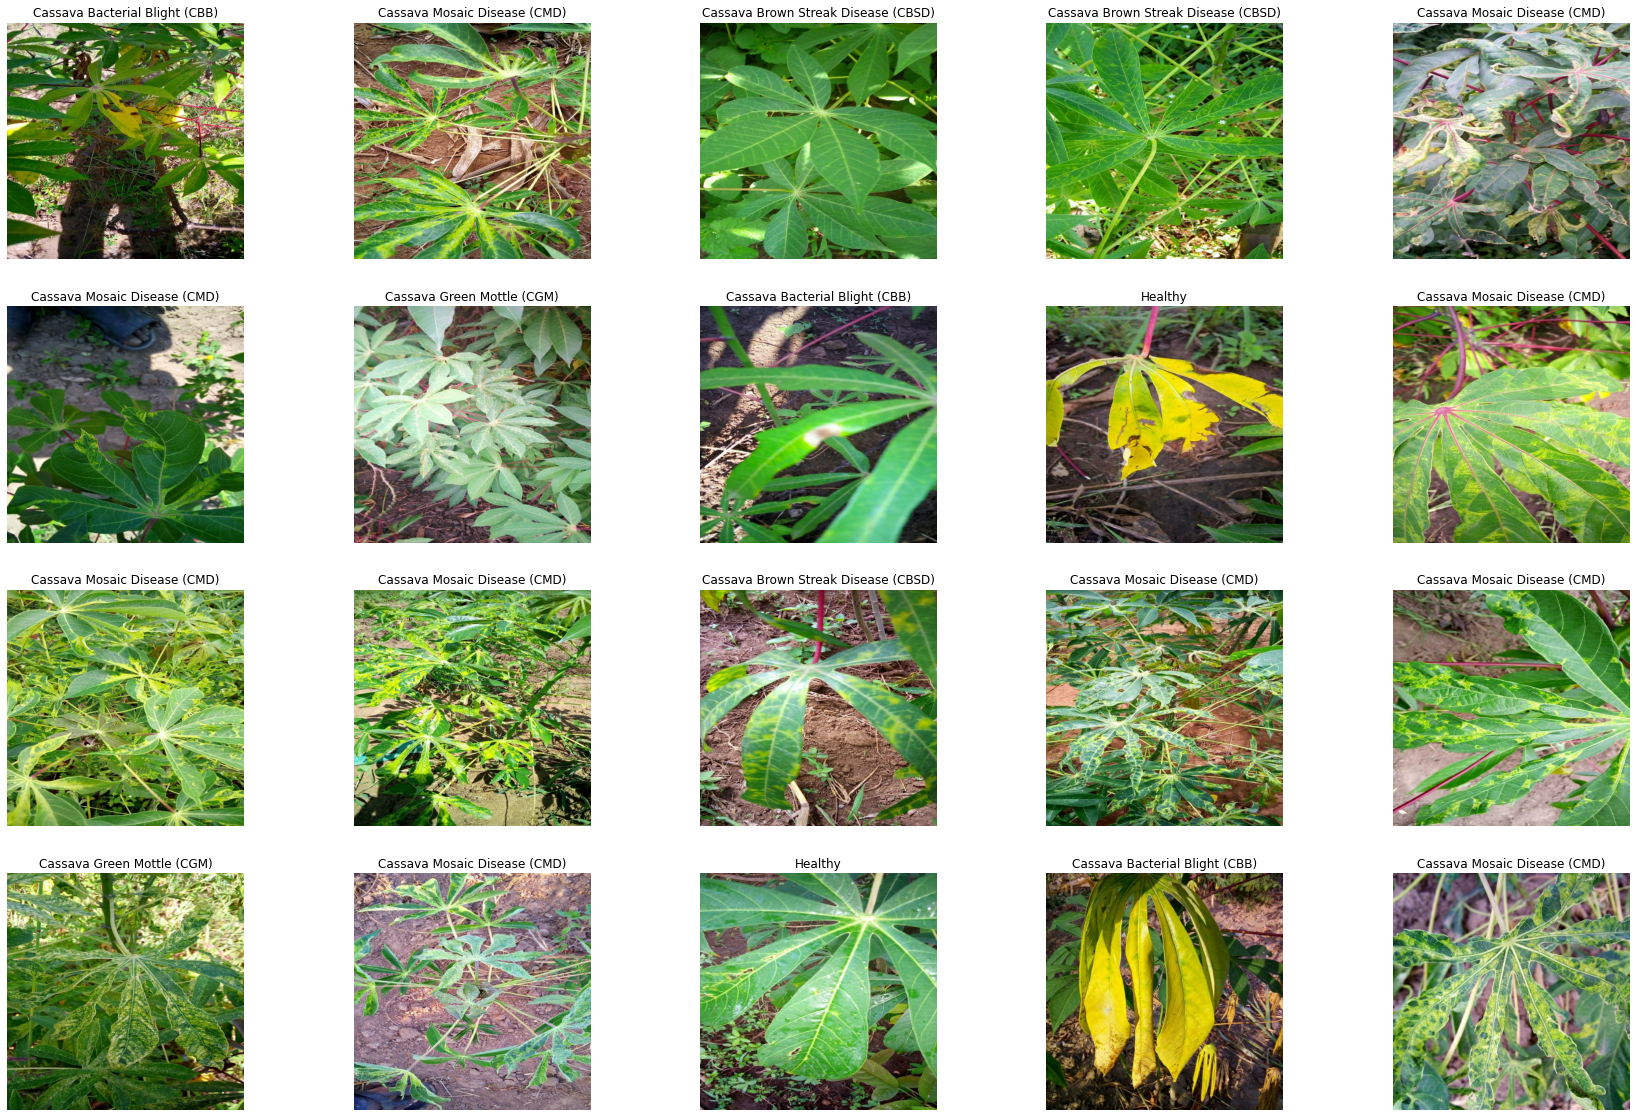

In [18]:
sample_show(TRAINING_FILENAMES, 4, 5, figsize=(30, 20), output_filename="sample.png")

In [19]:
label_count, labels_percent = explore_labels(TRAINING_FILENAMES)

gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train00-1338.tfrec
gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train01-1338.tfrec
gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train02-1338.tfrec
gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train03-1338.tfrec
gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train04-1338.tfrec
gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train05-1338.tfrec
gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train06-1338.tfrec
gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train07-1338.tfrec
gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc9/train_tfrecords/ld_train08-1338.tfrec
gs://kds-e118bcdb309cf88b7f9e4a96ee84997123a5781b886180ffc13d3fc

In [20]:
label_count

Cassava Bacterial Blight (CBB)  \
ld_train00-1338.tfrec                              58   
ld_train01-1338.tfrec                              61   
ld_train02-1338.tfrec                              66   
ld_train03-1338.tfrec                              71   
ld_train04-1338.tfrec                              55   
ld_train05-1338.tfrec                              64   
ld_train06-1338.tfrec                              87   
ld_train07-1338.tfrec                              58   
ld_train08-1338.tfrec                              68   
ld_train09-1338.tfrec                              80   
ld_train10-1338.tfrec                              74   
ld_train11-1338.tfrec                              75   
ld_train12-1338.tfrec                              70   
ld_train13-1338.tfrec                              69   
ld_train14-1338.tfrec                              62   
ld_train15-1327.tfrec                              69   
Total                                            1087   

                       Cassava Brown Streak Disease (CBSD)  \
ld_train00-1338.tfrec                                  148   
ld_train01-1338.tfrec                                  141   
ld_train02-1338.tfrec                                  127   
ld_train03-1338.tfrec                                  127   
ld_train04-1338.tfrec                                  130   
ld_train05-1338.tfrec                                  137   
ld_train06-1338.tfrec                                  147   
ld_train07-1338.tfrec                                  145   
ld_train08-1338.tfrec                                  146   
ld_train09-1338.tfrec                                  128   
ld_train10-1338.tfrec                                  129   
ld_train11-1338.tfrec                                  125   
ld_train12-1338.tfrec                                  149   
ld_train13-1338.tfrec                                  126   
ld_train14-1338.tfrec                                  140   
ld_train15-1327.tfrec                                  144   
Total                                                 2189   

                       Cassava Green Mottle (CGM)  \
ld_train00-1338.tfrec                         146   
ld_train01-1338.tfrec                         157   
ld_train02-1338.tfrec                         164   
ld_train03-1338.tfrec                         145   
ld_train04-1338.tfrec                         145   
ld_train05-1338.tfrec                         160   
ld_train06-1338.tfrec                         138   
ld_train07-1338.tfrec                         147   
ld_train08-1338.tfrec                         134   
ld_train09-1338.tfrec                         165   
ld_train10-1338.tfrec                         162   
ld_train11-1338.tfrec                         150   
ld_train12-1338.tfrec                         146   
ld_train13-1338.tfrec                         147   
ld_train14-1338.tfrec                         142   
ld_train15-1327.tfrec                         138   
Total                                        2386   

                       Cassava Mosaic Disease (CMD)  Healthy  
ld_train00-1338.tfrec                           837      149  
ld_train01-1338.tfrec                           816      163  
ld_train02-1338.tfrec                           820      161  
ld_train03-1338.tfrec                           827      168  
ld_train04-1338.tfrec                           829      179  
ld_train05-1338.tfrec                           809      168  
ld_train06-1338.tfrec                           819      147  
ld_train07-1338.tfrec                           814      174  
ld_train08-1338.tfrec                           841      149  
ld_train09-1338.tfrec                           820      145  
ld_train10-1338.tfrec                           803      170  
ld_train11-1338.tfrec                           826      162  
ld_train12-1338.tfrec                           821      152  
ld_train13-1338.tfrec                     

In [21]:
labels_percent

Cassava Bacterial Blight (CBB)  \
ld_train00-1338.tfrec                        0.043348   
ld_train01-1338.tfrec                        0.045590   
ld_train02-1338.tfrec                        0.049327   
ld_train03-1338.tfrec                        0.053064   
ld_train04-1338.tfrec                        0.041106   
ld_train05-1338.tfrec                        0.047833   
ld_train06-1338.tfrec                        0.065022   
ld_train07-1338.tfrec                        0.043348   
ld_train08-1338.tfrec                        0.050822   
ld_train09-1338.tfrec                        0.059791   
ld_train10-1338.tfrec                        0.055306   
ld_train11-1338.tfrec                        0.056054   
ld_train12-1338.tfrec                        0.052317   
ld_train13-1338.tfrec                        0.051570   
ld_train14-1338.tfrec                        0.046338   
ld_train15-1327.tfrec                        0.051997   
Total                                        0.050802   

                       Cassava Brown Streak Disease (CBSD)  \
ld_train00-1338.tfrec                             0.110613   
ld_train01-1338.tfrec                             0.105381   
ld_train02-1338.tfrec                             0.094918   
ld_train03-1338.tfrec                             0.094918   
ld_train04-1338.tfrec                             0.097160   
ld_train05-1338.tfrec                             0.102392   
ld_train06-1338.tfrec                             0.109865   
ld_train07-1338.tfrec                             0.108371   
ld_train08-1338.tfrec                             0.109118   
ld_train09-1338.tfrec                             0.095665   
ld_train10-1338.tfrec                             0.096413   
ld_train11-1338.tfrec                             0.093423   
ld_train12-1338.tfrec                             0.111360   
ld_train13-1338.tfrec                             0.094170   
ld_train14-1338.tfrec                             0.104634   
ld_train15-1327.tfrec                             0.108515   
Total                                             0.102304   

                       Cassava Green Mottle (CGM)  \
ld_train00-1338.tfrec                    0.109118   
ld_train01-1338.tfrec                    0.117339   
ld_train02-1338.tfrec                    0.122571   
ld_train03-1338.tfrec                    0.108371   
ld_train04-1338.tfrec                    0.108371   
ld_train05-1338.tfrec                    0.119581   
ld_train06-1338.tfrec                    0.103139   
ld_train07-1338.tfrec                    0.109865   
ld_train08-1338.tfrec                    0.100149   
ld_train09-1338.tfrec                    0.123318   
ld_train10-1338.tfrec                    0.121076   
ld_train11-1338.tfrec                    0.112108   
ld_train12-1338.tfrec                    0.109118   
ld_train13-1338.tfrec                    0.109865   
ld_train14-1338.tfrec                    0.106129   
ld_train15-1327.tfrec                    0.103994   
Total                                    0.111511   

                       Cassava Mosaic Disease (CMD)   Healthy  
ld_train00-1338.tfrec                      0.625561  0.111360  
ld_train01-1338.tfrec                      0.609865  0.121824  
ld_train02-1338.tfrec                      0.612855  0.120329  
ld_train03-1338.tfrec                      0.618087  0.125561  
ld_train04-1338.tfrec                      0.619581  0.133782  
ld_train05-1338.tfrec                      0.604634  0.125561  
ld_train06-1338.tfrec                      0.612108  0.109865  
ld_train07-1338.tfrec                      0.608371  0.130045  
ld_train08-1338.tfrec                      0.628550  0.111360  
ld_train09-1338.tfrec                      0.612855  0.108371  
ld_train10-1338.tfrec                      0.600149  0.127055  
ld_train11-1338.tfrec                      0.617339  0.121076  
ld_train12-1338.tfrec                      0.613602  0.113602  
ld_train13-1338.tfrec       

In [22]:
class_weights = 1 / (5 * labels_percent.loc["Total", :].to_numpy())
class_weights = (class_weights > 1) * class_weights + (1) * (class_weights < 1)
class_weights

array([3.93689052, 1.9549566 , 1.79354568, 1.        , 1.66061312])

In [23]:
label_count.to_pickle("label_count.pickle")
labels_percent.to_pickle("label_percent.pickle")
np.save("class_weights.pickle", class_weights)

# Models

In [24]:
def model_def1(input_shape):
    batch = tf.keras.Input(input_shape)
           
    #Preprocess for efficientnetB0
    preprocessed = tf.keras.Sequential(
        [
            tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),
            tf.keras.layers.BatchNormalization(momentum=0.9, scale=False)
        ], name="Preprocessed"
    )(batch)
    
    
    #Load efficientnetB0 model
    #"https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
    pretrained = tf.keras.Sequential(
        tf.keras.models.load_model(KaggleDatasets().get_gcs_path("efficientnet-b0")),
        name = "pretrained"
    )
    pretrained.trainable = False
    
    #Get Features
    features = pretrained(preprocessed, training=False)    

    #Classifier
    classifier = tf.keras.Sequential(
        [
            tf.keras.layers.BatchNormalization(momentum=0.9),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(500, use_bias=False, activation=tf.keras.layers.LeakyReLU(0.01)),
            tf.keras.layers.BatchNormalization(momentum=0.9),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(200, use_bias=False, activation=tf.keras.layers.LeakyReLU(0.01)),
            tf.keras.layers.BatchNormalization(momentum=0.9),
            tf.keras.layers.Dense(5, activation='softmax')
        ], name = "classifier"
    )(features)


    # Create model from batch and final classifier
    model = tf.keras.Model(inputs=batch, outputs=classifier)

    return model, ["pretrained"], {
        "Text>simple_swish": tf.nn.swish,
        "Text>identity": tf.identity,
        "LeakyReLU": tf.keras.layers.LeakyReLU
    }

In [25]:
def model_def2(input_shape):
    batch = tf.keras.Input(input_shape)
           
    #Preprocess for efficientnetB0
    preprocessed = tf.keras.Sequential(
        [
            tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),
            tf.keras.layers.BatchNormalization(momentum=0.9, scale=False)
        ], name="Preprocessed"
    )(batch)
    
    
    #Load efficientnetB0 model
    #"https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
    pretrained = tf.keras.Sequential(
        tf.keras.models.load_model(KaggleDatasets().get_gcs_path("efficientnet-b0")),
        name = "pretrained"
    )
    pretrained.trainable = False
    
    #Get Features
    features = pretrained(preprocessed, training=False)    

    #Classifier
    classifier = tf.keras.Sequential(
        [
            tf.keras.layers.BatchNormalization(momentum=0.9),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(200, use_bias=False, activation=tf.keras.layers.LeakyReLU(0.01)),
            tf.keras.layers.BatchNormalization(momentum=0.9),
            tf.keras.layers.Dense(5, activation='softmax')
        ], name = "classifier"
    )(features)


    # Create model from batch and final classifier
    model = tf.keras.Model(inputs=batch, outputs=classifier)

    return model, ["pretrained"], {
        "Text>simple_swish": tf.nn.swish,
        "Text>identity": tf.identity,
        "LeakyReLU": tf.keras.layers.LeakyReLU
    }

In [26]:
def model_def3(input_shape):
    batch = tf.keras.Input(input_shape)
           
    #Preprocess for efficientnetB0
    preprocessed = tf.keras.Sequential(
        [
            tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),
            tf.keras.layers.BatchNormalization(momentum=0.9, scale=False)
        ], name="Preprocessed"
    )(batch)
    
    
    #Load efficientnetB5 model
    #"https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1"
    pretrained = tf.keras.Sequential(
        tf.keras.models.load_model(KaggleDatasets().get_gcs_path("efficientnet-b5")),
        name = "pretrained"
    )
    pretrained.trainable = False
    
    #Get Features
    features = pretrained(preprocessed, training=False)    

    #Classifier
    classifier = tf.keras.Sequential(
        [
            tf.keras.layers.BatchNormalization(momentum=0.9),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(200, use_bias=False, activation=tf.keras.layers.LeakyReLU(0.01)),
            tf.keras.layers.BatchNormalization(momentum=0.9),
            tf.keras.layers.Dense(5, activation='softmax')
        ], name = "classifier"
    )(features)


    # Create model from batch and final classifier
    model = tf.keras.Model(inputs=batch, outputs=classifier)

    return model, ["pretrained"], {
        "Text>simple_swish": tf.nn.swish,
        "Text>identity": tf.identity,
        "LeakyReLU": tf.keras.layers.LeakyReLU
    }

## Model training

In [27]:
def save_weights(self, filepath, *args, **kwargs):
    """
    This function will replace a model default save_weights function, saving the weights using pickle.
    
    Usage:
        model.save_weights = types.MethodType(save_weights, model)
    """
    with open(filepath, 'wb') as f:
        pickle.dump(self.get_weights(), f)

        
def set_freeze_state(model, pretrained, fining_tunning):
    """
    This function freezes|unfreezes the pretrained models
    
    If fining_tunning is true they are unfreezed. Otherwise they are freezed.
    
    ps: BatchNormalization layers are never unfreezed
    """
    for pre in pretrained:
        pre_model = model.get_layer(name=pre)
        
        if fining_tunning:
            pre_model.trainable = True
        
            # This loop assumes that the pretrained was wrapped in sequential and is the first layer in it
            for layer in pre_model.layers[0].layers:
                if isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = False
                    layer.momentum = 0.9
                else:
                    layer.trainable = True
        else:
            pre_model.trainable = False
            
            # This loop assumes that the pretrained was wrapped in sequential and is the first layer in it
            for layer in pre_model.layers[0].layers:
                layer.trainable = False

def model_training(
    model_def, strategy, model_file_path, x, y=None, validation_data=None,
    batch_size=None, epochs=[20,20], steps_per_epoch=None, validation_steps=None
):    
    print("########START MODEL TRAINING############################")
        
    checkpoints_defs = [
        ["val_categorical_accuracy", "max", "acc"],
        ["val_loss", "min", "loss"],
        ["val_f1_score_micro", "max", "f1_score_micro"],
        ["val_f1_score_macro", "max", "f1_score_macro"]
    ]
    
    checkpoints = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f"{model_file_path}.{fsuffix}.pickle", verbose=1,
            save_best_only=True, save_weights_only=True, monitor=metric, mode=mode
        )
        for metric, mode, fsuffix in checkpoints_defs
    ]
            
    training_rountine = [
        (tf.keras.optimizers.Adam(learning_rate=0.01), False),
        (
            tf.keras.optimizers.SGD(
                learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(0.001,20,0.1), momentum=0.9, nesterov=True
            ), False
        ),
        (tf.keras.optimizers.Adam(learning_rate=0.0001), True),
        (
            tf.keras.optimizers.SGD(
                learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(0.00001,20,0.1), momentum=0.9, nesterov=True
            ), True
        )
    ]
        
    for i, (optimizer, fine_tunning) in enumerate(training_rountine):
        routine_type = "Fine Tunning" if fine_tunning else "Normal"
        print(f"{chr(10) if i > 0 else ''}Training Routine {i} -> {routine_type} with {optimizer.__class__.__name__}")
        print("############################################")
        with strategy.scope():
            # If model doesn't exist, instantiate it
            if i == 0:
                model, pretrained, custom_objects = model_def()
                model.save_weights = types.MethodType(save_weights, model) 
                 
            set_freeze_state(model, pretrained, fine_tunning)

            # compile the model
            model.compile(
                loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics = [
                    'categorical_accuracy',
                    tf.keras.metrics.Recall(name="recall"),
                    tf.keras.metrics.Precision(name="precision"),
                    tfa.metrics.F1Score(num_classes=5, average="micro", name="f1_score_micro"),
                    tfa.metrics.F1Score(num_classes=5, average="macro", name="f1_score_macro")
                ],
                steps_per_execution=8
            )

        hist = model.fit(
            x=x, y=y, validation_data=validation_data,
            batch_size=batch_size, epochs=(epochs[1] if fine_tunning else epochs[0]),
            steps_per_epoch=steps_per_epoch,verbose=1,
            validation_steps=validation_steps,
            callbacks=[
                *checkpoints,
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", verbose=1)
            ]
        )
        
        tf.keras.backend.clear_session()
        gc.collect()
        
        # load the weights that yielded less loss
        with open(f"{model_file_path}.loss.pickle", 'rb') as f:
            model.set_weights(pickle.load(f))
        print("############################################")
 

    eval_res = {}
    for _, _, fsuffix in checkpoints_defs:
        with open(f"{model_file_path}.{fsuffix}.pickle", 'rb') as f:
            model.set_weights(pickle.load(f))
        eval_res[fsuffix] = model.evaluate(x=validation_data, verbose=0, return_dict=True, steps=validation_steps)
    
    
    print("")
    print(eval_res)
    print("########ENDING MODEL TRAINING############################\n\n\n")
    
    #Cleanup. Trying to free memory
    del x, y, validation_data, model
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    gc.collect()
    
    return eval_res

### Training With Strategy

In [28]:
@subprocess
def model_strategy(
    training_filenames, validation_filenames, model_def, img_size=(512, 512),
    batch_size_per_core=16, epochs=20, class_weights=None, model_file_name=""
):
    tf.random.set_seed(int.from_bytes(os.urandom(4), sys.byteorder))
    np.random.seed()
    
    with get_strategy() as strategy:
        # Calculate batch size
        batch_size = batch_size_per_core * strategy.num_replicas_in_sync
        print("Batch size:", batch_size)

        return model_training(
            functools.partial(model_def, input_shape=(img_size + (3,))), strategy, model_file_name,
            x = load_dataset(
                training_filenames, batch_size=batch_size, img_size=img_size, validation=False, class_weights=class_weights
            ),
            validation_data = load_dataset(validation_filenames, batch_size=batch_size, img_size=img_size, validation=True),
            epochs=epochs,
            steps_per_epoch=count_data_items(training_filenames) // batch_size,
            validation_steps=count_data_items(validation_filenames) // batch_size
        )

### Cross Validation

In [29]:
def cross_valid(
    training_filenames, n_splits, model_def, img_size=(512, 512), batch_size_per_core=16, epochs=20,
    class_weights=None, model_dir_path="", model_prefix=""
):
    # Instantiate KFOLD
    kf = sk.model_selection.KFold(n_splits, shuffle = True)
    
        
    metrics = [
        model_strategy(
            training_filenames[train_index], training_filenames[val_index], model_def,
            img_size, batch_size_per_core, epochs, class_weights, os.path.join(model_dir_path, f"{model_prefix}.{i}.best")
        )
        for i, (train_index, val_index) in enumerate(kf.split(np.arange(len(training_filenames))))
    ]
    
    with open(f"{model_prefix}.best_metrics.pickle", 'wb') as f:
        pickle.dump(metrics, f)

In [ ]:
cross_valid(
    TRAINING_FILENAMES, n_splits=5, model_def=model_def3, img_size=(456,456),
    batch_size_per_core=8, epochs=(100,100), model_prefix="cassavaleaf_model3withweights",
    class_weights=class_weights
)

In [ ]:
cross_valid(
    TRAINING_FILENAMES, n_splits=5, model_def=model_def3, img_size=(456,456),
    batch_size_per_core=8, epochs=(100,100), model_prefix="cassavaleaf_model3"
)

In [ ]:
cross_valid(
    TRAINING_FILENAMES, n_splits=5, model_def=model_def2, img_size=(224, 224),
    batch_size_per_core=16, epochs=(100,100), model_prefix="cassavaleaf_model2"
)

In [30]:
cross_valid(
    TRAINING_FILENAMES, n_splits=5, model_def=model_def1, img_size=(224, 224),
    batch_size_per_core=16, epochs=(100,100), model_prefix="cassavaleaf_model1",
    class_weights=class_weights
)

Number of replicas: 1
Batch size: 64
########START MODEL TRAINING############################
Training Routine 0 -> Normal with Adam
############################################
Epoch 1/100
160/250 [==================>...........] - ETA: 1:05 - loss: 2.3868 - categorical_accuracy: 0.5357 - recall: 0.4094 - precision: 0.6312 - f1_score_micro: 0.5357 - f1_score_macro: 0.3195

KeyboardInterrupt: 

Process Process-3:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-4-d0281aaa521b>", line 7, in _run
    queue.put((1,) + (func(*args,**kwargs),))
  File "<ipython-input-28-a0c1c18fc3d5>", line 22, in model_strategy
    validation_steps=count_data_items(validation_filenames) // batch_size
  File "<ipython-input-27-a62f3bd10f95>", line 109, in model_training
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", verbose=1)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 1100, in fit
    tmp_logs = self.train_function(iterator)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File 